In [1]:
% matplotlib inline
import time
import os, os.path
import glob
import keras
import matplotlib
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input
from shutil import copyfile
import numpy as np
import pandas as pd
import numpy as np

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [7]:
# directory where images are stored
DIR = "/storage/image/images/"
DIRCluster  = "/storage/clusterimages/"

In [8]:
file_names = [file for file in os.listdir(DIR)]

In [9]:
# Load the models with ImageNet weights
resnet50_model = keras.applications.resnet50.ResNet50(include_top=False, weights="imagenet", input_shape=(224,224,3))

/usr/local/lib/python3.5/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [10]:
#Function that loops through each image and pre-process the data depending on the model type. 
def fitmodel(model):
    X_train=[]
    for img_path in file_names:
        #print(str(img_path))
        targetsize=(224,224)
        if model=='INCEPTION':
            targetsize = (299,299)
        img = image.load_img(DIR + '/' + str(img_path), target_size=targetsize)
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        if model=='VGG16':
            x = keras.applications.vgg16.preprocess_input(x)
            features = vgg16_model.predict(x)
        elif model=='VGG19':
            x = keras.applications.vgg19.preprocess_input(x)
            features = vgg19_model.predict(x)
        elif model=='RESNET':
            x = keras.applications.resnet50.preprocess_input(x)
            features = resnet50_model.predict(x)
        else:
            x = keras.applications.inception_v3.preprocess_input(x)
            features = inceptionv3_model.predict(x)
            
        #print(features.shape)
        features = np.array(features)
        features= features.flatten()
        X_train.append(features)
    return X_train

In [11]:
resnet50_output = fitmodel('RESNET')

In [12]:
# Function that creates a PCA instance, fits it to the data and returns the instance
def create_fit_PCA(data, n_components=None):
    p = PCA(n_components=n_components, random_state=728)
    p.fit(data)
    return p

In [13]:
# Create PCA instances for each covnet output
resnet50_pca = create_fit_PCA(resnet50_output)


In [14]:
#Funtion to plot the PCA
def pca_cumsum_plot(pca):
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    plt.show()

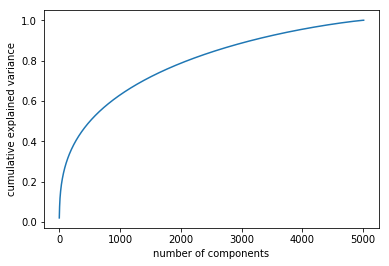

In [15]:
# Plot the cumulative explained variance for each covnet
pca_cumsum_plot(resnet50_pca)


In [16]:
# PCA transformations of covnet outputs
resnet50_output_pca = resnet50_pca.transform(resnet50_output)


In [17]:
#Fit the images to the Kmeans algo
def create_train_kmeans(data, number_of_clusters=20):
    
    k= KMeans(init='k-means++', max_iter=100, n_clusters=15)

    # Train the model
    k.fit(data)
    k.predict(data)

    return k

In [18]:
#Pass thr data to the K-Means and see how images are classified
K_resnet50_pca = create_train_kmeans(resnet50_output_pca)

In [100]:
#Function to prepare the output based on the labels.
def clusterit (cluster, clustername):
    df=pd.DataFrame({'image': [], 'cluster':[]}) 
    x=1
    p=dict(zip(file_names,cluster.labels_))
    for i,j in p.items() :
        j='cluster_' + str(j)
        source = DIR + '/' + i
        destdir=DIRCluster + clustername + '/' +  j
        dest=destdir + '/' + i
        #print(dest)
        df=df.append({'image':i, 'cluster':j }, ignore_index=True)
    return df

In [101]:
df=clusterit(K_resnet50_pca, 'RESNET_pca')


In [102]:
df.head(10)

,cluster,image
0,cluster_14,02759.jpg
1,cluster_7,04518.jpg
2,cluster_5,03600.jpg
3,cluster_13,03282.jpg
4,cluster_10,00198.jpg
5,cluster_10,01798.jpg
6,cluster_11,01548.jpg
7,cluster_14,01904.jpg
8,cluster_5,04929.jpg
9,cluster_13,01087.jpg


In [103]:
df.to_csv('ImageClassifierResnet15.csv', sep=',')